In [3]:
import os
import pandas as pd
import sys
import json
from google.protobuf.json_format import Parse

sys.path.insert(0, 'compiled_protobufs')
from taskmap_pb2 import TaskMap

qrels_folder = os.path.join(os.getcwd(), 'measurements', 'judgments')
run_cooking_folder = os.path.join(os.getcwd(), 'measurements', 'cooking', 'run_files')
run_diy_folder = os.path.join(os.getcwd(), 'measurements', 'diy', 'run_files')
cooking_runs = os.listdir(run_cooking_folder)
cooking_qrles = os.path.join(qrels_folder, "cooking.qrles")

queries = {
    "COOKING" : pd.read_csv('queries/cooking.csv'),
    "DIY": pd.read_csv('queries/diy.csv'),
}


In [4]:
import ir_measures
from ir_measures import *
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np


def get_filepaths(folder):
  file_names = os.listdir(folder)
  return [os.path.join(folder, filename) for filename in file_names]

def get_accuracy(run_filepath, qrles_filepath):
    run = ir_measures.read_trec_run(run_filepath)
    qrles = ir_measures.read_trec_qrels(qrles_filepath)
    accuracy = ir_measures.calc_aggregate([nDCG@3, nDCG@5, nDCG@10, Precision@3, Precision@5, Precision@10, Recall@10, Recall@25, Judged@10, Judged@20, MAP], qrles, run)
    return accuracy

def get_precision_recall(run_filepath, qrles_filepath):
    run = ir_measures.read_trec_run(run_filepath)
    qrles = ir_measures.read_trec_qrels(qrles_filepath)
    precs = [IPrec@round(p,1) for p in np.arange(0,1.1,0.1)]
    iprec = ir_measures.calc_aggregate(precs, qrles, run)
    return iprec

def show_iprecs(results_iprec):
  precison_scores = np.arange(0, 1.1, 0.1)
  fig, ax = plt.subplots(figsize=(7,6))

  for model_name, res in results_iprec.items():
    recall_scores = res
    ax.plot(precison_scores,recall_scores, drawstyle='steps-pre',label=model_name)
  

  ax.set_xticks(np.arange(0, 1.1, step=0.1))
  ax.set_yticks(np.arange(0, 1.1, step=0.1))
  ax.set_xlim(left=0)
  ax.set_title(f"Precision-Recall Curve")
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.grid(axis='both', linestyle='--')
  ax.legend(loc='upper right')


# def get_stats(run_filepath, qrles_filepath):
    # run = ir_measures.read_trec_run(run_filepath)
    # qrles = ir_measures.read_trec_qrels(qrles_filepath)
    # precs = [IPrec(rel=2)@round(p,1) for p in np.arange(0,1.1,0.1)]
    # iprec = ir_measures.calc_aggregate(precs, qrles, run)
    # return iprec

In [224]:
for searcher in cooking_runs:
    run = os.path.join(run_cooking_folder, searcher)
    searcher_name = searcher[:-4].lower()
    accuracy = get_accuracy(run, cooking_qrles)
    print(searcher_name, accuracy)
    

bm25+rm3 {nDCG@10: 0.44329738192839563, nDCG@5: 0.41115512795801795, P@5: 0.5166666666666667, Judged@20: 0.6458333333333334, AP: 0.26414729717991076, P@3: 0.5416666666666667, R@25: 0.3609831519791353, Judged@10: 1.0, R@10: 0.2622747604108365, nDCG@3: 0.42877152069010754, P@10: 0.5250000000000001}
marqo-target {nDCG@10: 0.3404694735639611, nDCG@5: 0.33174737416883704, P@5: 0.4166666666666667, Judged@20: 0.5312500000000001, AP: 0.18244202730950032, P@3: 0.4861111111111111, R@25: 0.2512456256057462, Judged@10: 0.9916666666666667, R@10: 0.21730908212972902, nDCG@3: 0.3667353052237145, P@10: 0.425}
tct-colbertv2+t5-contents {nDCG@10: 0.5581451527391029, nDCG@5: 0.6405771869733564, P@5: 0.6166666666666668, Judged@20: 0.5000000000000001, AP: 0.31506558945086055, P@3: 0.708333333333333, R@25: 0.4247951502648845, Judged@10: 0.6208333333333332, R@10: 0.2645179276234442, nDCG@3: 0.7112240407078415, P@10: 0.4958333333333332}
bm25+rm3+t5 {nDCG@10: 0.5944226000495846, nDCG@5: 0.6472008887419592, P@5

In [225]:


diy_runs = os.listdir(run_diy_folder)
diy_qrles = os.path.join(qrels_folder, "diy.qrles")

results = {}
for searcher in sorted(diy_runs):
    run = os.path.join(run_diy_folder, searcher)
    searcher_name = searcher[:-4].lower()
    # print(searcher_name, run)
    accuracy = get_accuracy(run, diy_qrles)
    results[searcher_name] = accuracy
    # print(searcher_name, accuracy)
    # print(type(accuracy))
    
df = pd.DataFrame(results).transpose()
# df[["AP", "nDCG@3", "nDCG@5", "nDCG@10", "P@3", "P@5", "P@10", "R@10", "R@25"]]
df

,nDCG@10,nDCG@5,P@5,Judged@20,AP,P@3,R@25,Judged@10,R@10,nDCG@3,P@10
tct-colbertv2+t5,0.705826,0.731114,0.788,0.6470,0.564691,0.840000,0.691018,0.855,0.503270,0.744540,0.641
tct-colbertv2,0.649280,0.683120,0.726,0.5790,0.515468,0.806667,0.632784,0.775,0.459690,0.728618,0.576
ance+t5,0.674036,0.718328,0.772,0.5560,0.500027,0.820000,0.606364,0.790,0.470103,0.738191,0.602
ance,0.595871,0.639273,0.662,0.4845,0.421227,0.750000,0.531427,0.675,0.389222,0.694842,0.504
bm25+rm3+t5,0.721481,0.715442,0.782,0.7390,0.613461,0.810000,0.741127,1.000,0.545050,0.733648,0.701
bm25+rm3,0.617084,0.609331,0.702,0.7280,0.543364,0.743333,0.690939,1.000,0.468586,0.629136,0.617
bm25+t5,0.710791,0.703808,0.768,0.7495,0.598473,0.790000,0.734722,1.000,0.532561,0.721815,0.684
bm25,0.596877,0.606046,0.692,0.7390,0.521407,0.730000,0.679432,1.000,0.449393,0.624523,0.586
marqo+t5,0.695752,0.711584,0.772,0.6675,0.570700,0.823333,0.703315,0.858,0.501566,0.731833,0.636
marqo,0.579773,0.585291,0.660,0.6905,0.471012,0.710000,0.606340,1.000,0.429362,0.611005,0.548


TCT-ColBERTv2+t5.run [0.9627380952380953, 0.9393214285714288, 0.8879472471972473, 0.8029769756179017, 0.7300884052588161, 0.6397461147162545, 0.47776096908317683, 0.3835639235780983, 0.29402040243832755, 0.14252951978162978, 0.07749280749280749]
ance+t5.run [0.9469458874458876, 0.9263701298701299, 0.8416363913863912, 0.7813259836139091, 0.6758645488842083, 0.5462479996571731, 0.3801319341951998, 0.2617261541616859, 0.17273491738344682, 0.08159566886966267, 0.027427924848977478]
bm25+rm3+t5.run [0.9582536075036074, 0.9364397546897547, 0.879743867243867, 0.8329128926628926, 0.748924813353017, 0.6935636998692076, 0.5815693065333469, 0.4775981163111643, 0.36087562636888615, 0.23579155883875788, 0.1762106141037188]
bm25+t5.run [0.9543531746031745, 0.9278571428571428, 0.8654399350649348, 0.8088780141427199, 0.741641806002874, 0.6743724250140657, 0.5650690656786623, 0.47055276893590453, 0.33522266029659614, 0.2231520517645243, 0.15917285227161435]
marqo+t5.run [0.9424480519480519, 0.922078983

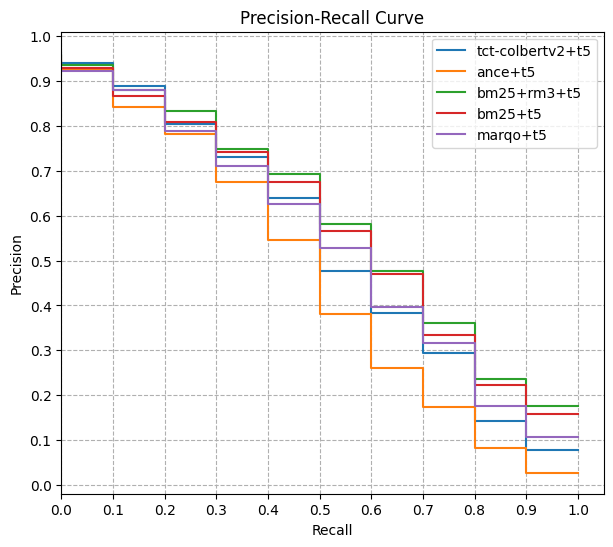

In [226]:
results_iprec = {}
precs = [IPrec@round(p,1) for p in np.arange(0,1.1,0.1)]
for searcher in sorted(diy_runs):
    if "t5" not in searcher:
      continue  
    run = os.path.join(run_diy_folder, searcher)
    searcher_name = searcher[:-4].lower()
    iprec = get_precision_recall(run, diy_qrles)
    vals = [iprec[prec] for prec in precs]
    results_iprec[searcher_name] = vals
    print(searcher, vals)
show_iprecs(results_iprec)

In [8]:
diy_runs = os.listdir(run_diy_folder)
diy_qrles = os.path.join(qrels_folder, "diy.qrles")

judgments = []
with open(diy_qrles, "r") as f:
    for j in f:
        judgment = j.strip().split(" ")
        judgment[3] = int(judgment[3])
        judgments.append(judgment)

diy_pd = pd.DataFrame(judgments, columns = ['qid', 'run', 'docid', "score"])

diy_pd.head()
stats_pd = diy_pd.groupby(by=["qid"])["score"].agg(['count', 'mean', 'std']).reset_index()
stats_pd["id"] = stats_pd["qid"].str.replace("query-", "").astype(int)
stats_pd = stats_pd.sort_values(by=['id'])
stats_pd.head()


,qid,count,mean,std,id
0,query-0,49,0.632653,0.782461,0
1,query-1,44,0.772727,0.742830,1
12,query-2,38,0.605263,0.679406,2
23,query-3,29,0.655172,0.720905,3
34,query-4,50,0.620000,0.752953,4


(-0.5, 2.263213955692383)

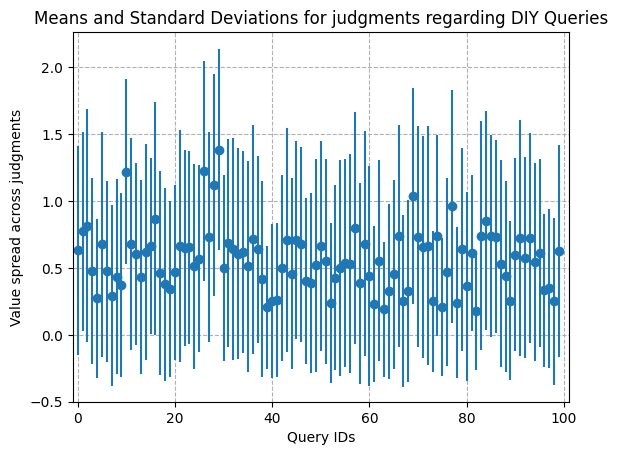

In [228]:
import matplotlib.pyplot as plt
 
plt.errorbar(x=stats_pd.index, y=stats_pd["mean"], yerr=stats_pd["std"], fmt='o')
plt.title("Means and Standard Deviations for judgments regarding DIY Queries")

plt.xlabel('Query IDs')
plt.ylabel('Value spread across judgments')
plt.grid(linestyle='--')
plt.xlim(-1,101)
plt.ylim(-0.5)

In [7]:
stats_pd = stats_pd[stats_pd["mean"] > 1]
stats_pd.head(10)

NameError: name 'stats_pd' is not defined

In [231]:
# diy_queries = queries["DIY"]
# for label, query in stats_pd.iterrows():
#     query = diy_queries[diy_queries["id"] == query["qid"]].iloc[0]
#     print(query)

In [19]:
def get_run_df(filepapth): 
    judgments = []
    with open(filepapth, "r") as f:
        for j in f:
            judgment = j.strip().split(" ")
            judgment[4] = float(judgment[4])
            judgments.append(judgment)
    cols = ['query_id', 'run', 'doc_id', "rank", "score", "model_name"]
    df = pd.DataFrame(judgments, columns=cols)

    return df

def get_qrles_df(filepath):
    judgments = []
    with open(diy_qrles, "r") as f:
        for j in f:
            judgment = j.strip().split(" ")
            judgment[3] = int(judgment[3])
            judgments.append(judgment)
    df = pd.DataFrame(judgments, columns = ['query_id', 'run', 'doc_id', 'relevance']) 
    return df

def get_metric_per_query(df_qrles, df_run, metric, model_name):
    query_ids = df_run["query_id"].unique()
    accuracies = []
    for q_id in query_ids:
        filtered_df_run = df_run[df_run["query_id"] == q_id]
        filtered_df_qrels = df_qrles[df_qrles["query_id"] == q_id]
        run = get_ir_measures_run(filtered_df_run)
        qrels = get_ir_measures_qrels(filtered_df_qrels)
        accuracy = ir_measures.calc_aggregate(measures=[metric], run=run, qrels=qrels)
        accuracies.append({
            "metric_val" : accuracy[metric],
            "query_id" : q_id,
            "model": model_name
        })
    return accuracies

def get_ir_measures_qrels(qrels):
    return [ir_measures.Qrel(qrel["query_id"], qrel["doc_id"], qrel["relevance"]) for index, qrel in qrels.iterrows()]

def get_ir_measures_run(run):
    return [ir_measures.ScoredDoc(score["query_id"], score["doc_id"], score["score"]) for index, score in run.iterrows()]

def get_metrics(run_folder, qrels_file, metric):
    run_files = get_filepaths(run_folder)
    df_qrles = get_qrles_df(qrels_file)
    scores = []
    for file in run_files:
        model_name = file.split('/')[-1].split(".")[0]
        df_run = get_run_df(file)
        scores += get_metric_per_query(df_qrles, df_run, metric, model_name)
    return pd.DataFrame(scores)

ap_vals = get_metrics(run_diy_folder, diy_qrles, AP)
recall_vals = get_metrics(run_diy_folder, diy_qrles, Recall@50)
ndcg_vals = get_metrics(run_diy_folder, diy_qrles, nDCG@10)

results = {}
results["DIY"] = {
    "MAP": ap_vals,
    "Recall@50": recall_vals,
    "Ndgc@10": ndcg_vals,
}

analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis"

for metric, df in results["DIY"].items():
    df.to_csv(os.path.join(analysis_folder, metric+".csv"), index=False)



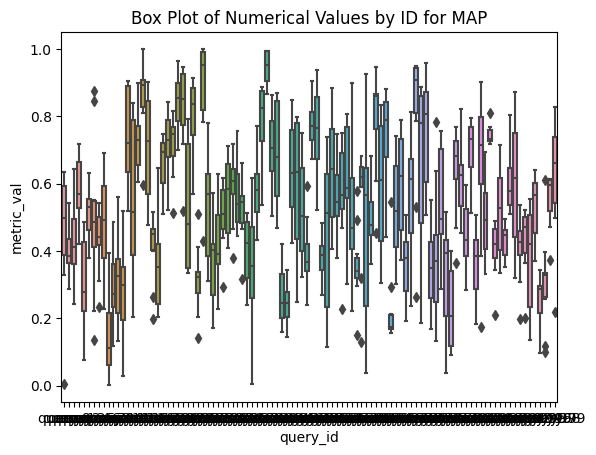

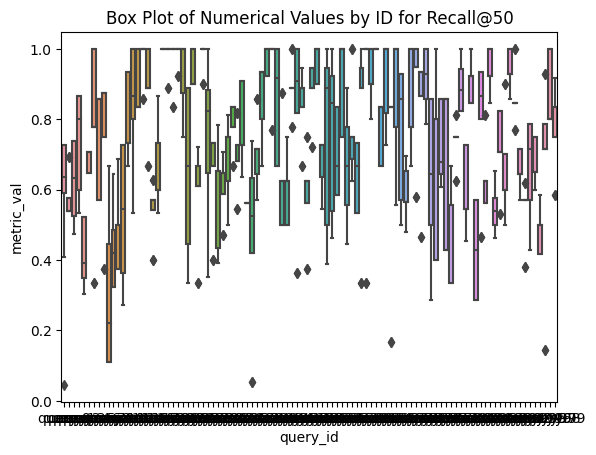

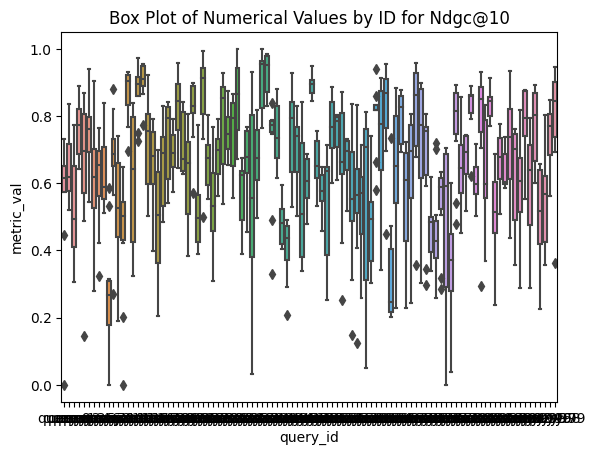

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis"

for result in results["DIY"]:
    
    df = results["DIY"][result]
    index = df.groupby(by=["query_id"])["metric_val"].transform(max) == df['metric_val']

    metric_best = df[index].sort_values(["query_id"])
    metric_best.to_csv(os.path.join(analysis_folder, f"diy-{result}-best.csv"), index=False)

    model_names = df["model"].unique()
    queries_list = []
    for model_name in model_names:
        best_queries_for_map = metric_best[metric_best["model"] == model_name]
        for i, query in best_queries_for_map.iterrows():
            query_row = queries["DIY"][queries["DIY"]["id"] == query["query_id"]].iloc[0]
            queries_list.append([query["query_id"], query_row["raw query"], model_name])
        
    queries_list_pd = pd.DataFrame(queries_list)
    queries_list_pd.to_csv(os.path.join(analysis_folder, f"diy-{result}-best-elaboration.csv"), index=False)


    sns.boxplot(x=df["query_id"], y=df["metric_val"])
    plt.title(f"Box Plot of Numerical Values by ID for {result}")
    plt.show()